<a href="https://colab.research.google.com/github/chalsai/Time-Series-Forecasting/blob/main/Week_8_Wednesday_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

### Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

### Data set

● The data is stored in the taxi.csv (https://bit.ly/3p1QPAv) file.
○ Download or import the dataset from the URL.
● The number of orders is in the num_orders column.

In [49]:
!pip install -qq catboost

In [50]:
#import libraries 
import numpy as np
import pandas as pd
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.linear_model import *
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize              
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import scipy.stats as scs
from scipy.signal import find_peaks

import random
random_state=42
random.seed(random_state)
np.random.seed(random_state)

import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [51]:
#Define functions for rolling mean

def rolling_means_plt(timeseries, window):
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

#Define functions for mean squar

def rmse_error(y_true, y_pred):
  return mean_squared_error(y_true, y_pred, squared=False)

#Define functions for mean absolute

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  
#Define functions for Plotting Model Results
    
def plotModelResults(model, X_train, X_test, y_train, y_test, plot_intervals=False, plot_anomalies=False):
    prediction = model.predict(X_test)
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    if plot_intervals:
        tscv = TimeSeriesSplit(n_splits=5)
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    mape = mean_absolute_percentage_error(prediction, y_test)
    rmse = rmse_error(prediction, y_test)
    plt.title(f"MAPE {mape:.2f}%, RMSE {rmse:.2f}")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

#Define functions for plotting Coeffiecients

def plotCoefficients(model):
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

# 1. Preparation

In [74]:
#Setting the table index and Change the data type of the Datetime data from object to datetime64
df = pd.read_csv("https://bit.ly/3p1QPAv", index_col=[0], parse_dates=[0])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [75]:
#check null
df.isnull().any()


num_orders    False
dtype: bool

**Observation**: Now the indices are sorted and we can see clearly.  To make it easier to analyze, let's try a smaller time interval like an hour

Resampling

,num_orders
datetime,
2018-03-01 00:00:00,20.666667
2018-03-01 01:00:00,14.166667
2018-03-01 02:00:00,11.833333
2018-03-01 03:00:00,11.000000
2018-03-01 04:00:00,7.166667


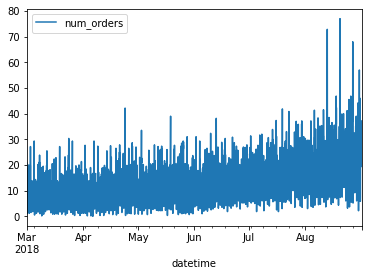

In [76]:
#Call the resample() function  with 1h as an argument. Then call the sort_index() function to sort
#sample per hour
df = df.resample('1h').mean().sort_index()
df.plot();

#sample per day
#data = df['2018-01':'2018-06'].resample('1D').sum()
#data.plot();
df.head()


In [73]:
df.describe()

,num_orders
count,4416.000000
mean,14.070463
std,7.503976
min,0.000000
25%,9.000000
50%,13.000000
75%,17.833333
max,77.000000


# 2. Analysis of data

In [60]:
#Function to prepare features data
def prepare_data(df, target="num_orders", window_size=6, n_lag=25):
  data = df.copy()
  data['rolling_mean'] = data[target].shift().rolling(window_size).mean()
  for lag in range(1, n_lag + 1):
    data["lag_{}".format(lag)] = data[target].shift(lag)#, fill_value=0)
  data['dayofweek'] = data.index.dayofweek
  data['month'] = data.index.month
  data['week'] = data.index.week
  data['dayofmonth'] = data.index.day
  data['hour'] = data.index.hour
  data['is_weekend'] = data.dayofweek.isin([5,6])*1
  data = data.dropna()
  return data

In [61]:
data = prepare_data(df)

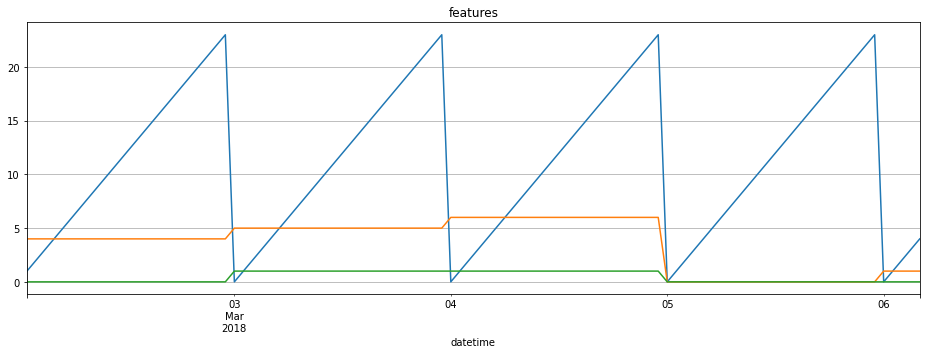

In [62]:
#Plot graph
plt.figure(figsize=(16, 5))
plt.title("features")
data[:100].hour.plot()
data[:100].dayofweek.plot()
data[:100].is_weekend.plot()
plt.grid(True);

let's plot rolling average (and std)

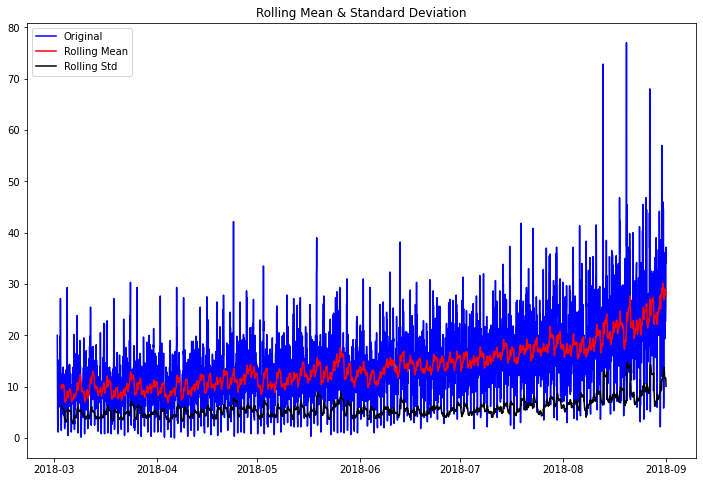

In [63]:
#rolling average 
rolling_means_plt(data["num_orders"], window=30)

stationary model

<div class="alert alert-block alert-success">
<b>Observation:</b> Great that original time series and rolling mean were visualized!
</div>

plot autocorellation graphs

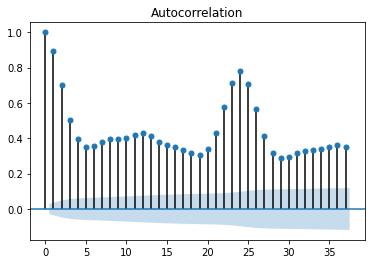

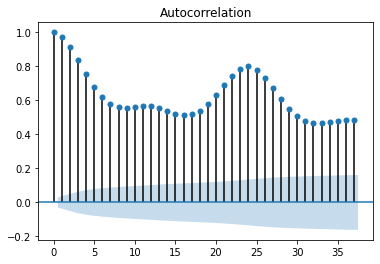

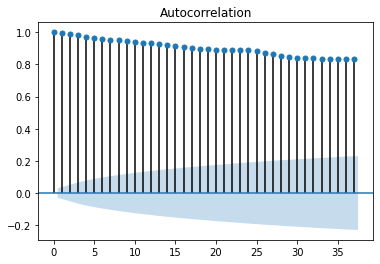

In [64]:
plot_acf(data["num_orders"].rolling(window=3).mean().dropna())
plot_acf(data["num_orders"].rolling(window=7).mean().dropna())
plot_acf(data["num_orders"].rolling(window=30).mean().dropna())
plt.show()

as we could see , we have seasonality, which we have to deal with prior to modeling. let's take the a simple subtraction of the series from itself with a lag that equals the seasonal period

for an Hour

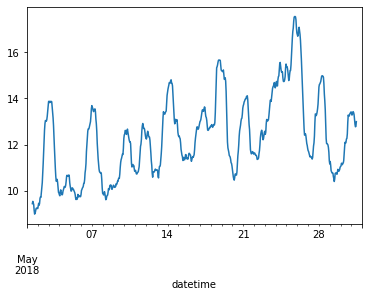

In [65]:
seasonal_decompose(data['2018-05-01':'2018-05-31'].resample('1H').sum().loc[:, target]).trend.plot()

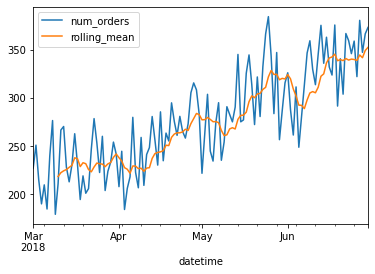

In [66]:
#Add a rolling mean with window size = 10 to the 'rolling_mean' column for 1 Day

df.sort_index(inplace=True)
data = df['2018-01':'2018-06'].resample('1D').sum()
data['rolling_mean'] = data.rolling(10).mean()
data.plot();

**Decompose a time series into trend and seasonal components**

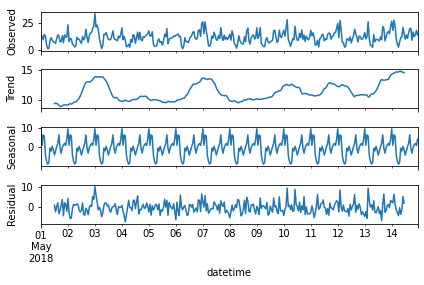

In [ ]:
#additive
result = seasonal_decompose(data['2018-05-01':'2018-05-14'].loc[:, 'num_orders'], model='additive')
result.plot()
plt.show()

as we could see,  the trend and seasonality extracted from the series does seem reasonable. according to residuals, we could see periods of high variability in the early and later periods(days) of the series

# 3. Training

# 4. Testing

In [67]:
#selecting target and features
target = "num_orders"
features = set(data.columns)-set([target])

suggestion: You could use train_test_split with 'shuffle=False' instead.

In [68]:
X, y = data[features], data[target]

In [69]:
#splitting training and test data 
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], shuffle=False, test_size=0.1)

In [70]:
print(X_train.index.min(), X_train.index.max())
print(X_test.index.min(), X_test.index.max())

2018-03-01 00:00:00 2018-06-17 00:00:00
2018-06-18 00:00:00 2018-06-30 00:00:00


### LinearRegression

In [71]:
rows = []
for i in range(1,X_train.shape[1]):
    lr = LinearRegression()
    lr.fit(X_train.iloc[:, :i], y_train)
    y_pred = lr.predict(X_test.iloc[:, :i])
    rows.append(dict(shifted=i, score=1-lr.score(X_test.iloc[:, :i], y_test), MSE=mean_squared_error(y_test, y_pred), RMSE=rmse_error(y_test, y_pred)))
stats_df = pd.DataFrame(rows)
stats_df

""


In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
plotCoefficients(lr)
plotModelResults(lr, X_train, X_test, y_train, y_test)

<div class="alert alert-block alert-info">
<b>Improve: </b> This coefficients are useless because scale of features is different.
</div>

>agree!

In [ ]:
stats_df.iloc[stats_df["RMSE"].argmin()]

shifted      29.000000
score         0.635342
MSE        2184.036539
RMSE         46.733677
Name: 28, dtype: float64

In [ ]:
best_shifted = int(stats_df.iloc[stats_df["RMSE"].argmin()]["shifted"])
best_shifted

29

<div class="alert alert-block alert-info">
<b>Improve: </b> What for you were adding features one by one? 
</div>

idea was, find some optimal result adding features by features and that's why I also saw best coeff. do the same strategy in the usual way, but in the time series case feel that's it's a bit tricky. if I understood correctly, the righteous way is doing ARIMA based model (for classical ML)

### RandomForestRegressor

In [ ]:
model = RandomForestRegressor().fit(X_train, y_train)
y_pred = model.predict(X_test)

print(rmse_error(y_pred, y_test))

42.23247063198906


In [ ]:
param_grid ={'n_estimators': range(50, 60, 5),
            'max_depth': range(8,16,4),
            'min_samples_split': range(10,40,10),
            'max_features':range(3,10,2)}

lets use mae insted of rmse for avoiding negative results as score

In [ ]:
rmse_scorer = make_scorer(rmse_error, greater_is_better=False)

In [ ]:
model = RandomForestRegressor(n_estimators=100)
tscv = TimeSeriesSplit(n_splits=5)
clf = GridSearchCV(model, scoring=rmse_scorer, param_grid=param_grid, n_jobs=4, cv=tscv).fit(X_train, y_train)
best_params = clf.best_params_
print(clf.best_score_)

-25.02419593334649


<div class="alert alert-block alert-info">
<b>Improve: </b> Please, print best validation score.
</div>

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> You should use TimeSeriesSplit() from sklearn as 'cv' parameter because default cross validation could not be used with time series data. It shuffles folds and train data can be from future and test from past.
</div>

completely agree, probably missed it occasionally, in the function plotModelResults, (in plot_intervals case) used TimeSeriesSplit, in this case made a mistake;)

In [ ]:
model = RandomForestRegressor(100).fit(X_train, y_train)
y_pred = model.predict(X_test)

print(rmse_error(y_pred, y_test))

41.47340858089894


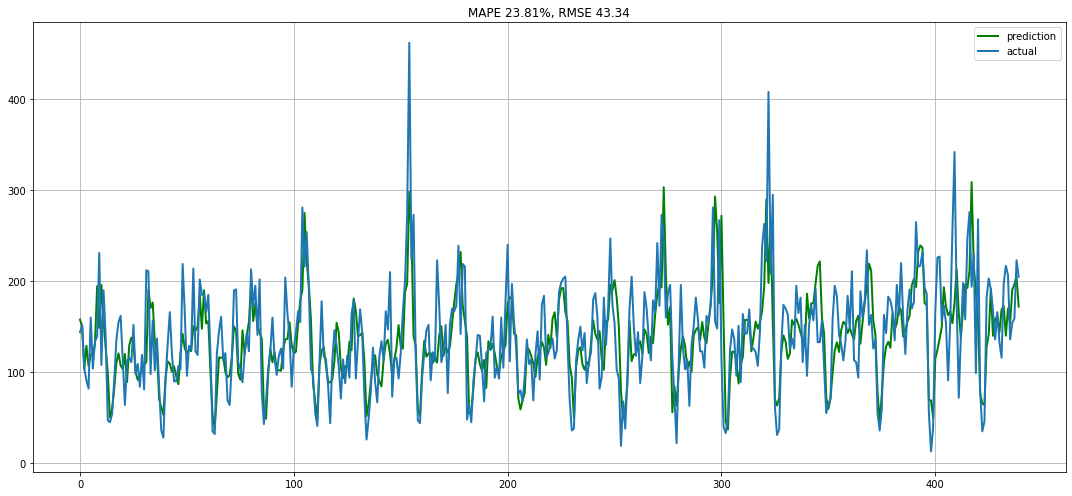

In [ ]:
model = RandomForestRegressor(20).fit(X_train, y_train)
plotModelResults(model, X_train, X_test, y_train, y_test)

<div class="alert alert-block alert-success">
<b>Success:</b> Great that you've visualized the result.
</div>

In [ ]:
best_params = 100

# Summary

we found that our model is non stationary, we built linear model and tree based model and found best result for tree based model and with rmse less than 41 which is enough. also we checked daily changes, week changes and found drift around 22-23 days

## Additional model: LSTM

I was curious about checking some simple LSTM model for the case

In [ ]:
import torch
import torch.nn as nn

In [ ]:
use_gpu = lambda x=True: torch.set_default_tensor_type(torch.cuda.FloatTensor 
                                             if torch.cuda.is_available() and x 
                                             else torch.FloatTensor)

In [ ]:
device = torch.device("cuda")

In [ ]:
train_data = torch.FloatTensor(X_train.values).to(device)
test_data = torch.FloatTensor(X_test.values).to(device)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=150, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=1, dropout=0.3)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))
        
     
    def to(self, device):
        super(LSTM, self).to(device)
        self.lstm = self.lstm.to(device)
        self.linear = self.linear.to(device)
        self.hidden_cell = tuple(map(lambda t: t.to(device), self.hidden_cell))
        self.device = device
        return self

    def reset_hidden_state(self):
        if self.device is not None:
            self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size).to(self.device),
                            torch.zeros(1, 1, self.hidden_layer_size).to(self.device))
        else:
            self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [ ]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [ ]:
model = LSTM().to(device)
loss_function = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 150
model.train()
for i in range(epochs):
    for seq, labels in zip(train_data, y_train):
        optimizer.zero_grad()
        model.reset_hidden_state()
        y_pred = model(seq)
        label = torch.FloatTensor([labels]).to(device)
        single_loss = loss_function(y_pred, label)
        single_loss.backward()
        optimizer.step()

    if i%25 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 71.47477722
epoch:  25 loss: 67.15249634
epoch:  50 loss: 62.23415375
epoch:  75 loss: 58.32328796
epoch: 100 loss: 55.68744659
epoch: 125 loss: 46.82424927
epoch: 149 loss: 49.5469207764


In [ ]:
model.eval()
y_pred = []
for i in range(len(test_inout_seq)):
  with torch.no_grad():
    model.reset_hidden_state()
    y_pred.append(model(test_inout_seq[i]).item())
y_pred = np.array(y_pred)
print(rmse_error(y_pred, y_test))

45.49893237334938


as we see, some simple LSTM model gave us really nice result,  less than 48